In [1]:
%matplotlib inline
import datetime, uuid
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

In [2]:
import fastai
print(fastai.__version__)

1.0.39.dev0


In [3]:
torch.cuda.set_device(0)

In [31]:
#DATE = datetime.datetime.today().strftime('%Y%m%d')
#UID=str(uuid.uuid4())[:8]

In [32]:
DATE = '20181224'

In [33]:
UID = '63d8a336'

In [7]:
# import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

It is mildly annoying that people are able to get to ~0.61 on the LB using a pretrained CNN on full images, which is a level of performance that has eluded us thus far. Let's see if we can change this!

To improve the score, these are some of the things we will do:
* train longer and on bigger images
* use biggger or newer architecture (though this is slightly annoying as it would make the training run much longer, maybe it can be avoided)
* use more data augmentation
* balancing the classes
* ~~more aggressively tune the threshold for the 'new_whale' label (this is also a great way to get into trouble on the test set)~~
* retrain on the entire train set (particularly important for whales with just a couple of pictures)
* if this does not give us adequate level of performance, I will attempt SWA or some other form of ensembling

## Prepare data

In [8]:
PATH = Path('../data/')

In [9]:
df = pd.read_csv(PATH/'train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [10]:
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df.sample(frac=1)[(df.Id != 'new_whale') & (df.sighting_count > 1)].groupby('Id').first().Image)

/home/walle/miniconda3/envs/fastai-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [11]:
# pd.to_pickle(val_fns, 'data/val_fns')
val_fns = pd.read_pickle(PATH/'val_fns')

In [12]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [13]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [14]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [15]:
name = f'res50-tuned-{SZ}'

### Create data loader

In [15]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], PATH/'train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder(PATH/'test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=PATH)
        .normalize(imagenet_stats)
)

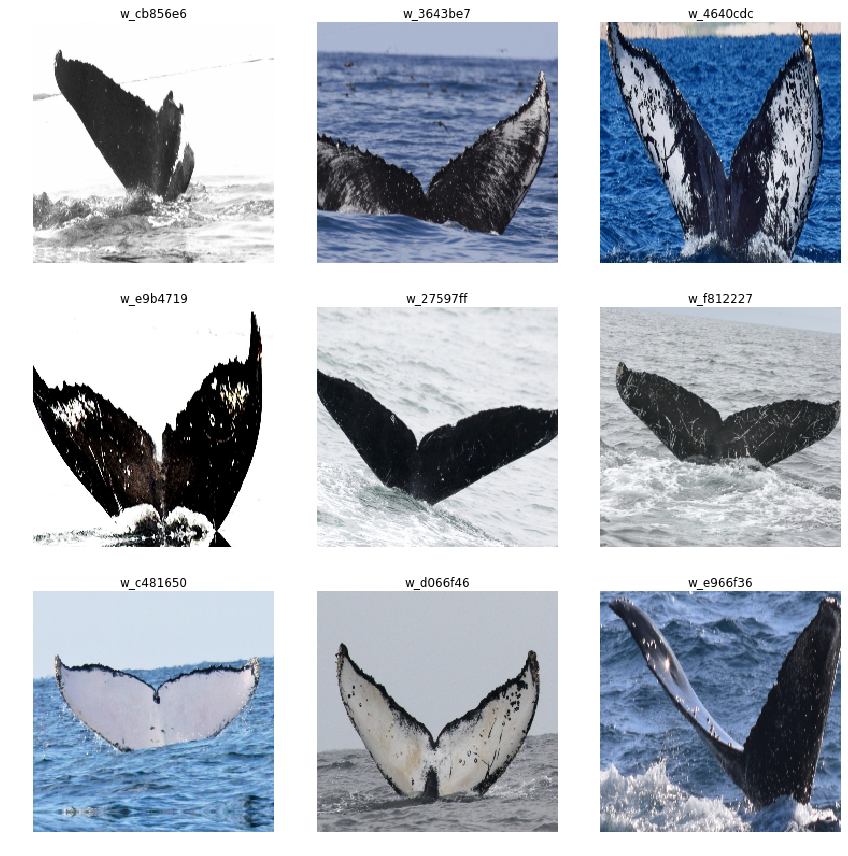

In [16]:
data.show_batch(rows=3)

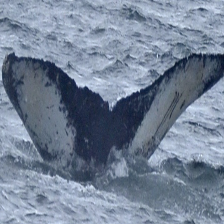

In [17]:
data.train_ds[1][0]

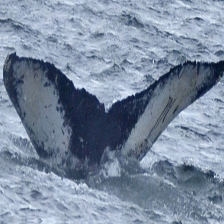

In [18]:
data.train_ds[1][0]

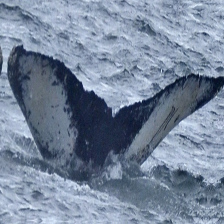

In [19]:
data.train_ds[1][0]

## Train

Warning - code below captures the gist of the experiments I ran, but now looking at the results I think I may have deleted some lines where I load weights, etc. Doesn't really matter, this still has all the info I need to train on the full train set.

In [21]:
# transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
learn.clip_grad();

learn.fit_one_cycle(12, 1e-2)

learn.unfreeze()

max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,7.476321,7.965424,0.030024,0.041863
2,6.842405,8.351965,0.033095,0.051012
3,6.275354,8.224989,0.051859,0.071193
4,5.313913,6.611865,0.103378,0.137507
5,4.384932,6.055934,0.153872,0.198891
6,3.550820,5.483641,0.211873,0.263841
7,2.518350,4.881106,0.283862,0.340930
8,1.563908,4.516359,0.349710,0.413289
9,0.815926,4.249942,0.401228,0.457563
10,0.387855,4.053190,0.427158,0.481047


epoch,train_loss,valid_loss,accuracy,map5
1,0.145816,3.950165,0.438417,0.494359
2,0.159424,4.069330,0.424087,0.483379
3,0.241779,4.157479,0.416240,0.472319
4,0.308608,4.241442,0.405322,0.461560
5,0.369226,4.424514,0.383487,0.444018
6,0.373916,4.337290,0.398499,0.459536
7,0.364385,4.330465,0.388605,0.448971
8,0.302116,4.366424,0.398158,0.460639
9,0.277899,4.113713,0.421358,0.481917
10,0.247885,4.065554,0.430570,0.490288


In [22]:
# SZ = 448
# transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
learn.clip_grad();

learn.fit_one_cycle(12, 1e-2)

learn.unfreeze()

max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(20, lrs)
learn.save('tmp')

epoch,train_loss,valid_loss,accuracy,map5
1,7.463860,7.971327,0.028318,0.040760
2,6.943450,8.741066,0.030024,0.045650
3,6.352653,7.944357,0.040942,0.061327
4,5.360690,6.848913,0.085636,0.119476
5,4.383424,6.083267,0.147049,0.189287
6,3.570156,5.417039,0.219379,0.272012
7,2.557764,4.958901,0.282497,0.338172
8,1.582820,4.461484,0.356534,0.414375
9,0.796945,4.264616,0.397816,0.451206
10,0.421546,4.070733,0.424429,0.480405


epoch,train_loss,valid_loss,accuracy,map5
1,0.145759,3.993765,0.430229,0.489964
2,0.169917,4.059559,0.416923,0.477653
3,0.217336,4.165329,0.410781,0.471756
4,0.291945,4.330476,0.387922,0.448266
5,0.337920,4.561573,0.382463,0.444558
6,0.407959,4.341977,0.398158,0.454868
7,0.343103,4.283145,0.403958,0.462902
8,0.308852,4.292082,0.411464,0.471438
9,0.281400,4.115400,0.418970,0.476845
10,0.213218,4.078056,0.435346,0.491078


### Load oversampled_train.csv

In [34]:
SZ = 224 * 2
BS = 64 // 4
NUM_WORKERS = 12
SEED=0

In [35]:
df = pd.read_csv(PATH/'oversampled_train.csv')

In [36]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], PATH/'train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder(PATH/'test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=PATH)
        .normalize(imagenet_stats)
)

In [37]:
# SZ = 448
# transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
# oversampled without val

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
learn.clip_grad();

CPU times: user 1.68 s, sys: 140 ms, total: 1.82 s
Wall time: 634 ms


### Train

learn.load('tmp');
learn.freeze_to(-1)

learn.fit_one_cycle(2, 1e-2 / 4)

In [20]:
learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,0.292849,3.001156,0.557148,0.603139
2,0.184817,2.807225,0.583419,0.629990
3,0.125004,2.679785,0.604913,0.647913


CPU times: user 56min 24s, sys: 20min 48s, total: 1h 17min 13s
Wall time: 1h 17min 11s


In [21]:
learn.save(f'stage_2_{DATE}_{UID}')

## Adding new_whale to predictions 

In [38]:
df = pd.read_csv(PATH/'train.csv')

In [39]:
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [ ]:
learn.load(f'stage_2_{DATE}_{UID}')

#### need to train with 'new_whale'

In [41]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:1000])
#new_whale_fns = set(df.loc[df['Id'] == 'new_whale'].Image.iloc[:1000])

In [42]:
list(new_whale_fns)[:10]

['3a04950af.jpg',
 '96db1b5b7.jpg',
 '46d868f5a.jpg',
 '46804b143.jpg',
 '8d43e3292.jpg',
 '35893743c.jpg',
 'be468863b.jpg',
 '861044cde.jpg',
 'f77f9f460.jpg',
 'c096a5371.jpg']

In [43]:
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [44]:
len(new_whale_fns)

1000

In [45]:
list(val_fns)[:10]

['2c0892b4d.jpg',
 '6aa5ee45c.jpg',
 '3cbb9bb68.jpg',
 '55faf2148.jpg',
 'e97aed73f.jpg',
 '68917859b.jpg',
 'cd90b71f7.jpg',
 '1184b2a6d.jpg',
 '2bd05c9ae.jpg',
 '2aa31dfa9.jpg']

In [48]:
len(list(val_fns.intersection(new_whale_fns))), len(list(val_fns.union(new_whale_fns)))

(0, 3931)

In [54]:
len(learn.data.classes)

5004

In [51]:
data = (
    ImageItemList
        .from_df(df, PATH/'train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns))
        #cant use learn.data.classes from previous as doesnt contain 'new_whale'
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=learn.data.classes)
        .add_test(ImageItemList.from_folder(PATH/'test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=PATH)
        .normalize(imagenet_stats)
)

Exception: Your validation data contains a label that isn't present in the training set, please fix your data.

In [ ]:
data

In [ ]:
learn.data = data

In [ ]:
preds, _ = learn.get_preds(DatasetType.Valid)

In [ ]:
classes = learn.data.classes + ['new_whale']

In [ ]:
targs = torch.tensor([classes.index(label.obj) if label else 5004 for label in learn.data.valid_ds.y])

In [ ]:
# without predicting new_whale
map5(preds, targs)

In [ ]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [ ]:
# always predicting new_whale with probability = 1
map5(preds, targs)

In [ ]:
%%time
res = []
ps = np.linspace(0, 1, 51)
for p in ps:
    preds[:, 5004] = p
    res.append(map5(preds, targs).item())

In [ ]:
best_p = ps[np.argmax(res)]; best_p

In [ ]:
# %%time

# # alternate way of estimating p, this didn't work
# # thinking more about this there is no reason this should work with our model,
# # but can be attempted if we have some better way of predicting new_whale
# res = []
# ps = np.linspace(0, 1, 51)
# for p in ps:
#     preds[:, 5004] = p
#     res.append(np.mean([lst.split()[0] == 'new_whale' for lst in top_5_pred_labels(preds, classes)]))
# 
# best_p = ps[np.argmin(np.abs(np.array(res) - 0.3))]; best_p # I assume the test set contains ~30% of new_whales

In [ ]:
preds[:, 5004] = best_p

In [ ]:
map5(preds, targs)

## Predict

In [ ]:
preds, _ = learn.get_preds(DatasetType.Test)

In [ ]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [ ]:
#preds[:, 5004] = best_p

In [ ]:
create_submission(preds, learn.data, name, classes)

In [ ]:
pd.read_csv(f'subs/{name}.csv.gz').head()

In [ ]:
pd.read_csv(f'subs/{name}.csv.gz').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

In [ ]:
#!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"